# Clean Scraped Data

In [1]:
import numpy as np
import pandas as pd
from fuzzywuzzy import process

# Read in the scraped file
gao = pd.read_json(r'./data/gao_composite.json')

# Convert dates listed to datetimes
gao['date'] = pd.to_datetime(gao['date'].str[19:-1])
gao['decision_made'] = pd.to_datetime(gao['decision_made'])

# Rename columns
columns_to_rename = {
                     'date': 'datePublished', 
                     'decision_made': 'dateDecided',
                     'decision_released': 'decision',
                     'bid_info': 'longDesc',
                     'desc': 'shortDesc',
                     'bid_url': 'url'
                    }

gao.rename(columns_to_rename, inplace=True, axis=1)

# Extract only bids with tables
gao['longDesc'] = gao['longDesc'].fillna('')
gao = gao[gao['longDesc'].str.contains('<tr>')]        

# Finding whether a protest was denied
desc_map = {}
for desc in gao['decision'].unique():
    if desc:
        matching, score = process.extractOne(desc.lower(), ['deny', 'dismiss', 'denied'])
        if score >= 70:
            desc_map[desc] = 'DENIED'
        else:
            desc_map[desc] = 'SUSTAINED'
     
# Applying that decision to our dataframe
gao['fuzzyDecision'] = gao['decision'].map(desc_map)
            
gao = gao[['fileID', 'datePublished', 'dateDecided', 'filer', 
           'decision', 'fuzzyDecision', 'highlights', 'shortDesc', 'longDesc',  'url']]

bids_denied = len(gao[gao['fuzzyDecision'] == 'DENIED'])

print(f"Percentage of bid evaluations (at least partly) denied: {bids_denied / len(gao)}")

# Selecting for bids that were DENIED
gao = gao[gao['fuzzyDecision'] == 'DENIED']

gao

C:\Users\614293\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Percentage of bid evaluations (at least partly) denied: 0.7604035308953342


,fileID,datePublished,dateDecided,filer,decision,fuzzyDecision,highlights,shortDesc,longDesc,url
0,"B-418730.5,B-418730.6",2021-06-25,2021-06-15,"Babel Street, Inc.",We deny the protest.,DENIED,"Babel Street, Inc., a small business of Reston...",\n DOCUMENT FOR PUBLIC RELEASE\nThe dec...,"<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-418730.5%2Cb-41...
5,"B-419368.2,B-419368.3",2021-06-16,2021-06-02,Journey Aviation LLC,We deny the protest.,DENIED,"Journey Aviation LLC (Journey), a small busine...",\n DOCUMENT FOR PUBLIC RELEASE\nThe dec...,"<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-419368.2%2Cb-41...
6,"B-419539,B-419539.2",2021-06-17,2021-04-28,"CGS Administrators, LLC",We deny the protest.,DENIED,"CGS Administrators, LLC, of Nashville, Tenness...",\n DOCUMENT FOR PUBLIC RELEASE\nThe dec...,"<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-419539%2Cb-4195...
13,"B-419659,B-419659.2",2021-06-07,2021-05-25,"American Electronics, Inc.",We deny the protest in part and dismiss it in ...,DENIED,"American Electronics, Inc. (Amelex), of Califo...",\n DOCUMENT FOR PUBLIC RELEASE\nThe dec...,"<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-419659%2Cb-4196...
15,"B-419597,B-419597.2",2021-06-03,2021-05-24,"Qwest Government Services, Inc. d/b/a CenturyL...",We deny the protest.,DENIED,"Qwest Government Services, Inc. d/b/a CenturyL...",\n DOCUMENT FOR PUBLIC RELEASE\nThe dec...,"<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-419597%2Cb-4195...
...,...,...,...,...,...,...,...,...,...,...
6010,"B-290716,B-290716.2",2002-09-23,2002-09-23,KPMG Consulting LLP,We deny the protest.,DENIED,KPMG Consulting LLP protests an award to Inter...,"\n B-290716; B-290716.2, KPMG Consultin...","<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-290716%2Cb-2907...
6011,"B-290733,B-290733.2",2002-09-23,2002-09-23,Albert Moving &amp; Storage,We deny the protest.,DENIED,Albert Moving & Storage protests the Departmen...,"\n B-290733; B-290733.2, Albert Moving ...","<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-290733%2Cb-2907...
6022,B-288818.6,2002-09-09,2002-09-09,"Sayed Hamid Behbehani &amp; Sons, WLL",GAO denies the protest.,DENIED,"Sayed Hamid Behbehani & Sons, WLL (SHBS) prote...","\n B-288818.6, Sayed Hamid Behbehani &a...","<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-288818.6-0
6037,"B-285882.3,B-285882.6",2001-07-02,2001-07-02,"J W Holding Group &amp; Associates, Inc",We deny the protest.,DENIED,"J.W. Holding Group & Associates, Inc. (JWH) pr...","\n B-285882.3; B-285882.6, J W Holding ...","<div class=""field-items-wrapper"">\n ...",https://www.gao.gov/products/b-285882.3%2Cb-28...


# Process longDesc html for table information

In [2]:
import html5lib

money_tables = []

# For each row in the GAO dataframe
for i, row in gao.iterrows():
    print(row.url)
    
    # Extract the tables from the HTML text
    all_tables = pd.read_html(row['longDesc'])
    
    # For each table found using read_html
    for tbl_num, tbl in enumerate(all_tables):
        
        # Replace the NAN values with empty strings
        tbl = tbl.fillna('')
        tbl_str = ''
        
        # For each row in the table
        for tbl_row in tbl.values:
            
            # Concatenate the text in a given row 
            # into a string
            tbl_row = [str(item) for item in tbl_row]
            tbl_row_str = ''.join(tbl_row).lower()
            tbl_str += tbl_row_str
        
        # Looking for tables that include a price 
        # (usually listed) with a '$' that do not 
        # have redacted/deleted information.
        if ('$' in tbl_str and 
            '[deleted]' not in tbl_str and
            '[redacted]' not in tbl_str):
            
            # Add reference information to tables, 
            # call filer "0" and fileID "1" so that 
            # they don't fuzzy match later on when 
            # determining the axis
            tbl['0'] = row.filer
            tbl['1'] = row.url
            
            # Final filter, getting rid of one-line
            # tables
            if len(tbl) > 1:
                money_tables.append(tbl)

https://www.gao.gov/products/b-418730.5%2Cb-418730.6
https://www.gao.gov/products/b-419368.2%2Cb-419368.3
https://www.gao.gov/products/b-419539%2Cb-419539.2
https://www.gao.gov/products/b-419659%2Cb-419659.2
https://www.gao.gov/products/b-419597%2Cb-419597.2
https://www.gao.gov/products/b-418735.3%2Cb-418735.4
https://www.gao.gov/products/b-419754%2Cb-419754.2
https://www.gao.gov/products/b-419588%2Cb-419588.2
https://www.gao.gov/products/b-419564
https://www.gao.gov/products/b-419040.3
https://www.gao.gov/products/b-417711.2%2Cb-417711.3
https://www.gao.gov/products/b-419629%2Cb-419629.2
https://www.gao.gov/products/b-419612%2Cb-419612.2
https://www.gao.gov/products/b-419646
https://www.gao.gov/products/b-419554%2Cb-419554.2
https://www.gao.gov/products/b-417950.5%2Cb-417950.6
https://www.gao.gov/products/b-418165.6%2Cb-418165.9
https://www.gao.gov/products/b-418400.7%2Cb-418400.8
https://www.gao.gov/products/b-419193.4%2Cb-419193.5%2Cb-419193.6
https://www.gao.gov/products/b-418604.3

https://www.gao.gov/products/b-418444%2Cb-418444.2
https://www.gao.gov/products/b-418419%2Cb-418419.2%2Cb-418419.4%2Cb-4184193
https://www.gao.gov/products/b-418320.2%2Cb-418320.3%2Cb-418320.4
https://www.gao.gov/products/b-417846.4%2Cb-417846.5
https://www.gao.gov/products/b-418397%2Cb-418397.2
https://www.gao.gov/products/b-418411%2Cb-418411.2%2Cb-418411.3
https://www.gao.gov/products/b-418384%2Cb-418384.2
https://www.gao.gov/products/b-418177%2Cb-418177.2%2Cb-418177.3%2Cb-418177.4%2Cb-418177.5
https://www.gao.gov/products/b-418382
https://www.gao.gov/products/b-416711.10
https://www.gao.gov/products/b-417852.2
https://www.gao.gov/products/b-416377.6%2Cb-416377.7
https://www.gao.gov/products/b-418403
https://www.gao.gov/products/b-415716.38
https://www.gao.gov/products/b-417024.6%2Cb-417024.7
https://www.gao.gov/products/b-416588.3%2Cb-416588.4
https://www.gao.gov/products/b-416654.5%2Cb-416654.6
https://www.gao.gov/products/b-417427.2
https://www.gao.gov/products/b-417805.5%2Cb-4178

https://www.gao.gov/products/b-417173%2Cb-417173.2
https://www.gao.gov/products/b-417128
https://www.gao.gov/products/b-417096%2Cb-417096.2%2Cb-417096.3%2Cb-417096.4
https://www.gao.gov/products/b-417092%2Cb-417092.2%2Cb-417092.3%2Cb-417092.4
https://www.gao.gov/products/b-417046
https://www.gao.gov/products/b-417065%2Cb-417065.2
https://www.gao.gov/products/b-414892.2%2Cb-414892.3%2Cb-414892.4%2Cb-414892.5%2Cb-414892.6
https://www.gao.gov/products/b-417105
https://www.gao.gov/products/b-414952.4
https://www.gao.gov/products/b-417084
https://www.gao.gov/products/b-416976.2%2Cb-416976.3%2Cb-416976.4
https://www.gao.gov/products/b-416933%2Cb-416933.2%2Cb-416933.3
https://www.gao.gov/products/b-417020%2Cb-417020.2
https://www.gao.gov/products/b-416947%2Cb-416947.2
https://www.gao.gov/products/b-416778.2%2Cb-416778.4
https://www.gao.gov/products/b-416992
https://www.gao.gov/products/b-416964.2%2Cb-416964.3
https://www.gao.gov/products/b-417100
https://www.gao.gov/products/b-417133
https://

https://www.gao.gov/products/b-415011
https://www.gao.gov/products/b-415243%2Cb-415243.2
https://www.gao.gov/products/b-415713%2Cb-415713.2
https://www.gao.gov/products/b-413982.4%2Cb-413982.6
https://www.gao.gov/products/b-415631%2Cb-415631.3%2Cb-415631.4
https://www.gao.gov/products/b-415343%2Cb-415343.2
https://www.gao.gov/products/b-415510.2%2Cb-415510.3%2Cb-415510.4
https://www.gao.gov/products/b-414511.3
https://www.gao.gov/products/b-412020.16%2Cb-412020.18%2Cb-412020.19
https://www.gao.gov/products/b-415421%2Cb-415421.2
https://www.gao.gov/products/b-415700
https://www.gao.gov/products/b-412521.2%2Cb-412521.3%2Cb-412521.4
https://www.gao.gov/products/b-415513%2Cb-415513.2
https://www.gao.gov/products/b-415568%2Cb-415568.2
https://www.gao.gov/products/b-415612
https://www.gao.gov/products/b-415368.2%2Cb-45368.3%2Cb-415368.4%2Cb-415368.6%2Cb-415368.7%2Cb-415368.8%2Cb-415368.9%2Cb-415368.10%2Cb-415368.11%2Cb-415368.12
https://www.gao.gov/products/b-415601
https://www.gao.gov/produ

https://www.gao.gov/products/b-413528
https://www.gao.gov/products/b-412998
https://www.gao.gov/products/b-411837.2%2Cb-411837.3%2Cb-411837.4%2Cb-411837.5%2Cb-411837.6%2Cb-411837.7%2Cb-411837.8%2Cb-411837.9%2Cb-411837.10
https://www.gao.gov/products/b-413478.3
https://www.gao.gov/products/b-413313%2Cb-413313.2
https://www.gao.gov/products/b-412475.4
https://www.gao.gov/products/b-413586
https://www.gao.gov/products/b-410719.10%2Cb-410719.11
https://www.gao.gov/products/b-413210%2Cb-413210.2
https://www.gao.gov/products/b-413409%2Cb-413409.2
https://www.gao.gov/products/b-413291
https://www.gao.gov/products/b-413486%2Cb-413486.2
https://www.gao.gov/products/b-413317%2Cb-413317.2
https://www.gao.gov/products/b-412846.2
https://www.gao.gov/products/b-413392
https://www.gao.gov/products/b-413406%2Cb-413406.2
https://www.gao.gov/products/b-413434
https://www.gao.gov/products/b-413311%2Cb-413311.2
https://www.gao.gov/products/b-410189.5%2Cb-410189.6
https://www.gao.gov/products/b-412402.2
ht

https://www.gao.gov/products/b-411513.2
https://www.gao.gov/products/b-411702%2Cb-411702.2%2Cb-411702.3
https://www.gao.gov/products/b-411427.2
https://www.gao.gov/products/b-410614.2
https://www.gao.gov/products/b-411650%2Cb-411650.2%2Cb-411650.3
https://www.gao.gov/products/b-411682%2Cb-411682.2
https://www.gao.gov/products/b-409872.3%2Cb-409872.4%2Cb-409872.5
https://www.gao.gov/products/b-411464%2Cb-411464.2
https://www.gao.gov/products/b-410354.2
https://www.gao.gov/products/b-411530%2Cb-411530.2
https://www.gao.gov/products/b-411593
https://www.gao.gov/products/b-410788.4%2Cb-410788.5%2Cb-410788.6%2Cb-410788.7
https://www.gao.gov/products/b-411554
https://www.gao.gov/products/b-411465%2Cb-411465.2
https://www.gao.gov/products/b-411459%2Cb-411459.2%2Cb-411459.3%2Cb-411459.4%2Cb-411459.5%2Cb-411459.6
https://www.gao.gov/products/b-411490%2Cb-411490.2
https://www.gao.gov/products/b-411492%2Cb-411492.2
https://www.gao.gov/products/b-411388
https://www.gao.gov/products/b-411473%2Cb-41

https://www.gao.gov/products/b-407273.53
https://www.gao.gov/products/b-409541%2Cb-409541.2%2Cb-409541.3%2Cb-409541.4%2Cb-409541.5
https://www.gao.gov/products/b-409635
https://www.gao.gov/products/b-406897.3
https://www.gao.gov/products/b-409139.2
https://www.gao.gov/products/b-408414.7%2Cb-408414.8
https://www.gao.gov/products/b-408336.3
https://www.gao.gov/products/b-409450%2Cb-409450.3
https://www.gao.gov/products/b-409398
https://www.gao.gov/products/b-409424
https://www.gao.gov/products/b-409451
https://www.gao.gov/products/b-408410.3
https://www.gao.gov/products/b-409391%2Cb-409391.2%2Cb-409391.3
https://www.gao.gov/products/b-408962.3%2Cb-408962.4
https://www.gao.gov/products/b-407791.5
https://www.gao.gov/products/b-408010.6%2Cb-408010.7
https://www.gao.gov/products/b-408661.3%2Cb-408661.4%2Cb-408661.5
https://www.gao.gov/products/b-409095%2Cb-409095.2
https://www.gao.gov/products/b-408587.2%2Cb-408587.3%2Cb-408587.4
https://www.gao.gov/products/b-409144%2Cb-409144.2
https://w

https://www.gao.gov/products/b-407621%2Cb-407621.2
https://www.gao.gov/products/b-407418
https://www.gao.gov/products/b-407179
https://www.gao.gov/products/b-407047
https://www.gao.gov/products/b-407234%2Cb-407234.2
https://www.gao.gov/products/b-406700.3
https://www.gao.gov/products/b-406729%2Cb-406729.2
https://www.gao.gov/products/b-407195%2Cb-407195.2
https://www.gao.gov/products/b-407168%2Cb-407168.2
https://www.gao.gov/products/b-407337
https://www.gao.gov/products/b-407170
https://www.gao.gov/products/b-407297%2Cb-407297.2
https://www.gao.gov/products/b-406841.2
https://www.gao.gov/products/b-406998%2Cb-406998.2
https://www.gao.gov/products/b-407190
https://www.gao.gov/products/b-407069%2Cb-407069.2
https://www.gao.gov/products/b-407152
https://www.gao.gov/products/b-406279.2%2Cb-406279.3%2Cb-406279.4
https://www.gao.gov/products/b-406798%2Cb-406798.2%2Cb-406798.3
https://www.gao.gov/products/b-407422
https://www.gao.gov/products/b-407061
https://www.gao.gov/products/b-406925
ht

https://www.gao.gov/products/b-402055
https://www.gao.gov/products/b-401736.3
https://www.gao.gov/products/b-401564.2
https://www.gao.gov/products/b-401844
https://www.gao.gov/products/b-400733.10%2Cb-400733.12%2Cb-400733.9
https://www.gao.gov/products/b-310102.6%2Cb-310102.7%2Cb-310102.8%2Cb-310102.9
https://www.gao.gov/products/b-401923
https://www.gao.gov/products/b-401754%2Cb-401754.2%2Cb-401754.3%2Cb-401754.4
https://www.gao.gov/products/b-401794%2Cb-401794.2
https://www.gao.gov/products/b-401701%2Cb-401701.2
https://www.gao.gov/products/b-400771.6
https://www.gao.gov/products/b-401825
https://www.gao.gov/products/b-401793
https://www.gao.gov/products/b-401802
https://www.gao.gov/products/b-401807%2Cb-401807.2
https://www.gao.gov/products/b-401689%2Cb-401689.2%2Cb-401689.3
https://www.gao.gov/products/b-401694%2Cb-401694.2
https://www.gao.gov/products/b-401654
https://www.gao.gov/products/b-401658-b-401658.2
https://www.gao.gov/products/b-401670
https://www.gao.gov/products/b-4016

https://www.gao.gov/products/b-298543.2
https://www.gao.gov/products/b-298572
https://www.gao.gov/products/b-297838.3
https://www.gao.gov/products/b-296493.5
https://www.gao.gov/products/b-297758.3
https://www.gao.gov/products/b-298293%2Cb-298293.2
https://www.gao.gov/products/b-297136.10%2Cb-297136.11
https://www.gao.gov/products/b-294530.7
https://www.gao.gov/products/b-298020%2Cb-298020.2
https://www.gao.gov/products/b-298102
https://www.gao.gov/products/b-297994
https://www.gao.gov/products/b-297959%2Cb-297959.2
https://www.gao.gov/products/b-298011
https://www.gao.gov/products/b-297011.3%2Cb-297011.4
https://www.gao.gov/products/b-297879
https://www.gao.gov/products/b-294358.10%2Cb-294358.8%2Cb-294358.9
https://www.gao.gov/products/b-297691
https://www.gao.gov/products/b-297535.2%2Cb-297535.3%2Cb-297535.4
https://www.gao.gov/products/b-297508%2Cb-297508.2
https://www.gao.gov/products/b-297804
https://www.gao.gov/products/b-297252.3
https://www.gao.gov/products/b-297536
https://www

https://www.gao.gov/products/b-292382-0
https://www.gao.gov/products/b-292465-0
https://www.gao.gov/products/b-292515%2Cb-292515.2-0
https://www.gao.gov/products/b-292342-0
https://www.gao.gov/products/b-292392%2Cb-292392.2-0
https://www.gao.gov/products/b-291777.2
https://www.gao.gov/products/b-291170.4
https://www.gao.gov/products/b-292298%2Cb-292298.2%2Cb-292298.3-0
https://www.gao.gov/products/b-292407-0
https://www.gao.gov/products/b-292287-0
https://www.gao.gov/products/b-292312-0
https://www.gao.gov/products/b-292242-0
https://www.gao.gov/products/b-291978.2-0
https://www.gao.gov/products/b-291725.3%2Cb-291725.4%2Cb-291725.5-0
https://www.gao.gov/products/b-292165-0
https://www.gao.gov/products/b-292178%2Cb-292178.2%2Cb-292178.3-0
https://www.gao.gov/products/b-291642.2-0
https://www.gao.gov/products/b-291931.2-0
https://www.gao.gov/products/b-292182-0
https://www.gao.gov/products/b-292092-0
https://www.gao.gov/products/b-292237-0
https://www.gao.gov/products/b-292046%2Cb-292046

## Want to break the tables up and see which axis companies are listed on

- Need to fix the filer status, when there are multiple filers
- Need to fix tables that don't flip, a dollar sign that is 3 indices away from the end seems to be a good indicator of this
- Need to fix tables that don't have price on the bottom row - always seems to just be called "Price" so re-arranging this row might be useful
- Need to find difference between Total Proposed Price and Total Evaluated Price

In [3]:
from fuzzywuzzy import process

alligned_tables = []

for tbl in money_tables:
    
    # Data likely begins on row one
    # of the table, so we'll shift the table
    # down one row
    if tbl.columns[0] == 0:
        tbl = tbl.copy()
        # Rename columns
        column_names = tbl.iloc[0].values
        # 0_f for the filer, 1_u for the url.
        # using as few characters as possible
        # So these columns don't fuzzymatch any
        # of the companies.
        column_names[-2:] = ["0_f", "1_u"] 
        tbl.columns = column_names
        
        tbl = tbl.iloc[1:,:]
        
    # Use fuzzy matching to determine
    # if the company is referenced on this
    # axis 
    
    # Get the name of the filer
    filer = tbl.iloc[0, -2]
    
    # Get the abbreviated name of the filer
    # (ex. companies like Strategic Resources, Inc. 
    # abbreviate to SRI in some of these tables)
    filer_name, *_ = filer.replace('d/b/a/', ';').split('--')
    filer_abbrev = ''.join([word[0] for word in filer_name.split()])
    
    # Check and see if any values match the filer on the
    # top row, return highest fuzzymatching score 
    # from top row
    top_row = tbl.columns
    row_name, top_row_score = process.extractOne(filer, top_row)
    row_name_abbrev, top_row_score_abbrev = process.extractOne(filer_abbrev, top_row)
    
    # Check leftmost column, return highest 
    # fuzzymatching score from leftmost column
    leftmost_col = tbl.iloc[:, 0].values
    col_name, left_column_score = process.extractOne(filer, leftmost_col)
    col_name_abbrev, left_column_score_abbrev = process.extractOne(filer_abbrev, leftmost_col)
    
    # Transpose the table if the Y-axis
    # contains the company names
    if (left_column_score >= 90):
        transposed_tbl = tbl.T
        
        # Move the filer and url info to the
        # right of the table again
        filer = transposed_tbl.iloc[-2, -1]
        url = transposed_tbl.iloc[-1, -1]
        transposed_tbl = transposed_tbl.iloc[:-2, :]
        
        # Re-add the filer and URL info
        transposed_tbl["0_f"] = filer
        transposed_tbl["1_u"] = url
        
        if left_column_score >= 90:
            tbl = transposed_tbl.copy()
            
    alligned_tables.append(tbl)

### Troubleshooting with notes on where improvement could be used in this area

In [4]:
import random
# Edge cases 1603, 1568, 957, 1720, 788, 1754, 998
# Multi-index - 1659
# 1049 didn't flip, 447 didn't flip, 1006 didn't flip, 151, 1741, 1753, 1470, 1471
# Price is not on the bottom of the table - https://www.gao.gov/products/b-293088.3, https://www.gao.gov/products/b-293348, https://www.gao.gov/products/b-417639.2%2Cb-417639.3, https://www.gao.gov/products/b-404946.3, https://www.gao.gov/products/b-416964.2%2Cb-41..., https://www.gao.gov/products/b-299518%2Cb-2995...
# 1409 doesn't have column headers
i = random.randint(0, len(alligned_tables) - 1)
print(i)
print(alligned_tables[i].shape)
alligned_tables[i]

1345
(1, 7)


,,Raytheon,,,,0_f,1_u
1,Mission Capability,,,$240.3 million,$267.5 million,Northrop Grumman Systems Corporation,https://www.gao.gov/products/b-293036.5%2Cb-29...


## Get all tables that are properly formatted 
### (See if we have enought to start analysis)

In [5]:
# Find the substring that contains "$"
def index_containing_substring(the_list, substring):
    for i, s in enumerate(the_list):
        if substring in s:
              return i
    return -1

In [6]:
tables_with_price = []

# For each alligned table
for tbl in alligned_tables:
    
    # Convert the last row into strings to see
    # if the last row contains a dollar sign
    last_row = tbl.iloc[-1].values
    last_row = [str(item) for item in last_row]
    
    # If the last row contains strings to search
    if len(last_row) != 0:
        
        # Find the first instance where a dollar sign occurs
        first_dollar_sign_index = index_containing_substring(last_row, '$')
        
        # The index to the left of the first dollar sign 
        # indicates the start of row descriptors
        label = last_row[first_dollar_sign_index - 1]
        
        # If this descriptor explicitly describes "price" or
        # "cost" of the contract, add it to our new list of
        # dataframes
        if 'price' in label.lower() or 'cost' in label.lower():
            tables_with_price.append(tbl.iloc[:, (first_dollar_sign_index - 1):])

In [7]:
print(len(tables_with_price))

878


## Direct comparisons between only two companies

In [8]:
direct_comparisons = []
for i, tbl in enumerate(tables_with_price):
    rows, cols = tables_with_price[i].shape
    
    # Direct comparisons only have a table width
    # of 5 columns (these are the easiest tables
    # to work with)
    if cols == 5:
        direct_comparisons.append(tbl)

In [9]:
print(len(direct_comparisons))

698


## Convert the proposed value string to a float

In [10]:
# Create a backup copy so you don't need to use the
# compute to run it again if you mess the df objects up
direct_comparisons_bkup = direct_comparisons.copy()

In [11]:
import re

prices_as_floats = []

# Get the bid values as floats
def get_money_float_value(money_str):
    
    if "$" in money_str:
        money_lst = money_str.split('.')
        
        # We are working with an explicitly 
        # stated bid amount (ex $13,289,109)
        if len(money_lst) == 1:
            dollars, = money_lst
            cents = '0'
        elif len(money_lst) == 2:
            dollars, cents = money_lst
            
            # Billions always have 3 sig figs,
            # Millions always have fewer than 3
            cents, *_ = cents.split(' ')
        
        # Remove the dollar sign and commas
        dollars = dollars[1:].replace(',', '')
        
        # If there are fewer than 5 figures
        # representing the amount of money, we are
        # probably working in millions or billions
        if len(dollars) < 5:
            
            # Billions always have 3 sig figs, if there
            # are 3 sig figs we are probably dealing in 
            # billions
            if len(cents) >= 3:
                dollars = float(dollars)
                cents = float('.' + cents)
                return (dollars + cents) * 1e9
                
            # Otherwise going to assume we're working 
            # in millions
            else:
                dollars = float(dollars)
                cents = float('.' + cents)
                return (dollars + cents) * 1e6
        
        # We reach this point when we 
        # are returning explicitly stated values
        dollars = float(dollars)
        cents = float('.' + cents)
        return dollars + cents
    
for tbl in direct_comparisons_bkup:
    
    # Rename table columns
    initial_columns = list(tbl.columns)
    initial_columns[0] = "Factor"
    initial_columns[-2] = "Filer"
    initial_columns[-1] = "URL"
    tbl.columns = initial_columns
    
    for val in tbl.iloc[-1].values:
        if "$" in val:
            # Try to replace the dollar value with 
            # a float
            try:
                true_money_val = get_money_float_value(val)
                if true_money_val:
                    tbl.replace(val, true_money_val, inplace=True)
            except:
                print(f"MISSED VALUE - {val}")
    
    # If the prices were adjusted to represent floats,
    # proceed to the next round of cleaning
    if type(tbl.iloc[-1].values[1]) is float:
        prices_as_floats.append(tbl)

MISSED VALUE - $16,291,980 or $17,875,620[2]
MISSED VALUE - $75,985.807.74
MISSED VALUE - $171,240,019[5]
MISSED VALUE - $496,265,192[4]
MISSED VALUE - $98,307, 243
MISSED VALUE - $306 Million
MISSED VALUE - $314 Million
MISSED VALUE - $10,575,036  $65,537,922  $131,629,103  $207,742,062
MISSED VALUE - $17,322,233  $96,886,739  $151,486,717  $265,695,689
MISSED VALUE - $132.1M
MISSED VALUE - $125.3M
MISSED VALUE - $35,356,782[8]
MISSED VALUE - -$485,587.37
MISSED VALUE - $210 million
MISSED VALUE - $261 million
MISSED VALUE - $308 Million
MISSED VALUE - $280 Million
MISSED VALUE - $90.22M
MISSED VALUE - $87.46M
MISSED VALUE - $357.5 M/$358.4 M
MISSED VALUE - $368.8 M/$369.9 M
MISSED VALUE - $229 million
MISSED VALUE - $226 million
MISSED VALUE - $7,000,486[2]
MISSED VALUE - $372,814,177[4]
MISSED VALUE - $UTD[2]
MISSED VALUE - $82,294,908[14]
MISSED VALUE - $76,686,839[15]
MISSED VALUE - $17,640, 126
MISSED VALUE - $1,186,127[8]
MISSED VALUE - $27,137,559[7]
MISSED VALUE - $45,974,128[

In [12]:
print(f"Remaining tables to analyze: {len(prices_as_floats)}")

Remaining tables to analyze: 680


## Identify the Filer and the Winner

### Need to find a way to add the filer and winner columns to the dataframe. For some reason manual assignment isn't working

In [13]:
prices_as_floats[0]

,Factor,Babel,Dataminr,Filer,URL
0,Gateway,Acceptable,Acceptable,"Babel Street, Inc.",https://www.gao.gov/products/b-418730.5%2Cb-41...
1,Technical Approach,Acceptable,Outstanding,"Babel Street, Inc.",https://www.gao.gov/products/b-418730.5%2Cb-41...
2,Past Performance,Neutral Confidence,Substantial Confidence,"Babel Street, Inc.",https://www.gao.gov/products/b-418730.5%2Cb-41...
3,Price,6.75e+07,2.58661e+08,"Babel Street, Inc.",https://www.gao.gov/products/b-418730.5%2Cb-41...


In [14]:
# Use fuzzy matching to determine which
# Column the filer is in and which column 
# the winner is in
factors_of_interest = ['past performance', 'technical', 'management', 
                       'experience', 'small business', 'personnel', "market"]

# The flattened data of the comparison between
# two companies
flattened_output = []

for tbl in prices_as_floats:
    
    # Build a new dataframe where each column
    # represents the difference between the winner
    # of the bid and the filer of the protest
    new_tbl_row = {'FullFilerName': tbl.iloc[0]['Filer'],
                   'URL': tbl.iloc[0]['URL']}
    
    full_filer_name = new_tbl_row['FullFilerName']
    abbrev_filer_name = ''.join([word[0] for word in full_filer_name.split(' ')])
    column_names = list(tbl.columns)
    
    # Fuzzymatch against both full names and 
    # abbreviated names
    full_filer_in_tbl_name, full_name_score = process.extractOne(full_filer_name, column_names[1:3])
    abbrev_filer_in_tbl_name, abbrev_name_score = process.extractOne(abbrev_filer_name, column_names[1:3])
    
    # If the abbreviated name is a better match
    if abbrev_name_score > full_name_score:
        reference_name = abbrev_filer_in_tbl_name
    
    # If the full name is a better match
    else:
        reference_name = full_filer_in_tbl_name
    
    # Add the better-matched name of the filer to the row
    new_tbl_row['Filer'] = reference_name
        
    # Find the name of the bid winner
    filer_index = column_names.index(reference_name)
    if filer_index == 1:
        winner_index = 2
    else:
        winner_index = 1
        
    # Tag the winner
    new_tbl_row['Winner'] = column_names[winner_index]
    
    # Get the bid values for both companies
    winner_bid = tbl.iloc[-1, winner_index]
    filer_bid =  tbl.iloc[-1, filer_index]
    
    # If both values can be represented as floats
    try:
        # Add bid prices as rows to our table
        new_tbl_row['WinnerBid'] = float(winner_bid)
        new_tbl_row['FilerBid'] = float(filer_bid)
        
    except:
        print(f"Not a float: {new_tbl_row['URL']}")
    
    # Get the ratings for each candidate
    ratings = tbl.iloc[:-1,:-2].values
    for rating in ratings:
        factor = str(rating[0]).lower()
        factor, score = process.extractOne(factor, factors_of_interest)
        if score >= 80:
            # Add the winner's rating
            new_tbl_row[f'Winner_{factor}'] = rating[winner_index]
            # Add the filer's rating
            new_tbl_row[f'Filer_{factor}'] = rating[filer_index]
    
    # Append this new row of data to our 
    # flattened output list
    flattened_output.append(new_tbl_row)
    
# Consolidate the new rows into a dataframe,
# Slightly re-arrange the columns
bids = pd.DataFrame(flattened_output)
bids = bids[['FullFilerName', 'Filer', 'Winner', 'WinnerBid', 'FilerBid', 'Winner_technical', 'Filer_technical', 'Winner_past performance', 'Filer_past performance', 'Winner_personnel', 'Filer_personnel', 'Winner_management', 'Filer_management', 'Winner_experience', 'Filer_experience', 'Winner_small business', 'Filer_small business', 'URL']]

# Remove bids that don't have two explicitly stated
# prices
bids = bids[(bids['WinnerBid'].notna()) & (bids['FilerBid'].notna())]

# Lowercase data in all factors
factors = ['Winner_technical', 'Filer_technical', 'Winner_past performance', 'Filer_past performance', 'Winner_personnel', 'Filer_personnel', 'Winner_management', 'Filer_management', 'Winner_experience', 'Filer_experience', 'Winner_small business', 'Filer_small business']
for factor in factors:
    bids[factor] = bids[factor].str.lower()

bids.head()

Not a float: https://www.gao.gov/products/b-417686
Not a float: https://www.gao.gov/products/b-417774%2Cb-417774.2
Not a float: https://www.gao.gov/products/b-417171.2
Not a float: https://www.gao.gov/products/b-416680


Not a float: https://www.gao.gov/products/b-413352


Not a float: https://www.gao.gov/products/b-401694%2Cb-401694.2
Not a float: https://www.gao.gov/products/b-401079
Not a float: https://www.gao.gov/products/b-309803
Not a float: https://www.gao.gov/products/b-299548.2
Not a float: https://www.gao.gov/products/b-296090.4


,FullFilerName,Filer,Winner,WinnerBid,FilerBid,Winner_technical,Filer_technical,Winner_past performance,Filer_past performance,Winner_personnel,Filer_personnel,Winner_management,Filer_management,Winner_experience,Filer_experience,Winner_small business,Filer_small business,URL
0,"Babel Street, Inc.",Babel,Dataminr,2.586611e+08,67500000.0,outstanding,acceptable,substantial confidence,neutral confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-418730.5%2Cb-41...
1,"American Electronics, Inc.",Amelex,PSI Pax,4.532778e+07,47905997.0,outstanding,outstanding,satisfactory confidence,satisfactory confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419659%2Cb-4196...
2,"Qwest Government Services, Inc. d/b/a CenturyL...",CenturyLink,Verizon,1.576306e+08,283790911.0,exceeds,exceeds,high confidence,high confidence,meets,meets,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419597%2Cb-4195...
3,"Linchpin Solutions, Inc.",Linchpin,ACLC,3.320784e+07,33778624.0,good,good,substantial confidence,satisfactory confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419564
4,"Manhattan Strategy Group, LLC",MSG,STGi,1.281063e+07,13295714.0,good,acceptable,very low risk[2],low risk,good,good,good,acceptable,good,acceptable,NaN,NaN,https://www.gao.gov/products/b-419040.3


In [15]:
bids.head(10)

,FullFilerName,Filer,Winner,WinnerBid,FilerBid,Winner_technical,Filer_technical,Winner_past performance,Filer_past performance,Winner_personnel,Filer_personnel,Winner_management,Filer_management,Winner_experience,Filer_experience,Winner_small business,Filer_small business,URL
0,"Babel Street, Inc.",Babel,Dataminr,2.586611e+08,67500000.0,outstanding,acceptable,substantial confidence,neutral confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-418730.5%2Cb-41...
1,"American Electronics, Inc.",Amelex,PSI Pax,4.532778e+07,47905997.0,outstanding,outstanding,satisfactory confidence,satisfactory confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419659%2Cb-4196...
2,"Qwest Government Services, Inc. d/b/a CenturyL...",CenturyLink,Verizon,1.576306e+08,283790911.0,exceeds,exceeds,high confidence,high confidence,meets,meets,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419597%2Cb-4195...
3,"Linchpin Solutions, Inc.",Linchpin,ACLC,3.320784e+07,33778624.0,good,good,substantial confidence,satisfactory confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419564
4,"Manhattan Strategy Group, LLC",MSG,STGi,1.281063e+07,13295714.0,good,acceptable,very low risk[2],low risk,good,good,good,acceptable,good,acceptable,NaN,NaN,https://www.gao.gov/products/b-419040.3
5,Aviation Ground Equipment Corporation,AGEC,Essex,4.663822e+07,62553469.0,outstanding/low risk,outstanding/low risk,satisfactory confidence/very relevant,substantial confidence/relevant,NaN,NaN,outstanding/low risk,good/low risk,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-417711.2%2Cb-41...
6,"ENGlobal Government Services, Inc.",EGS,KBR,3.810918e+07,46749493.0,good,good,satisfactory confidence,satisfactory confidence,NaN,NaN,acceptable,good,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-419612%2Cb-4196...
7,"Candor Solutions, LLC",Candor Solutions (Protester),Systems Plus (Awardee),1.635129e+08,139903734.0,acceptable,acceptable,acceptable,acceptable,acceptable,acceptable,acceptable,acceptable,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-417950.5%2Cb-41...
8,"Morgan Business Consulting, LLC",Morgan,Synchron,1.069987e+08,119083198.0,good,good,substantial confidence,substantial confidence,good,good,acceptable,acceptable,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-418165.6%2Cb-41...
9,"CACI, Inc.-Federal",CACI,ManTech,9.493788e+07,120303456.0,some confidence,high confidence,low risk,low risk,NaN,NaN,some confidence,some confidence,NaN,NaN,NaN,NaN,https://www.gao.gov/products/b-418400.7%2Cb-41...


# Cleaning and Scoring Factors

### Implementing a Grading System for categorical variables

- A:  1.0
- B:  0.5
- C:  0.0
- D: -0.5
- F: -1.0

Colors
- Blue is outstanding
- Green is acceptable
- Yellow is satisfactory
- White is needs improvement
- Red is unacceptable

Need to think about how to deal with colors, risk, and numbers

In [16]:
# Remove brackets from values
def remove_brackets(s):
    if type(s) is str:
        l = s.split('[')
        if len(l) == 2:
            return l[0]
        l = s.split('(')
        if len(l) == 2:
            return l[0]
    return s
    
# Apply this function to each of our factors
for factor in factors:
    bids[factor] = bids[factor].apply(lambda string: remove_brackets(string))

bids['Winner_technical'].unique()

array(['outstanding', 'exceeds', 'good', 'outstanding/low risk',
       'acceptable', 'some confidence', nan, 'high confidence',
       'very good', '80', '', 'blue/outstanding', 'meets requirements',
       'excellent', 'yes', 'superior', '35.5', 'green', 'purple/good',
       'moderate', '94.5', 'exceptional', 'purple', 'low',
       'green/acceptable', 'marginal', 'blue/outstanding/low risk',
       'low risk', '28.67', 'minor benefit', 'green/good', 'excellent ',
       'satisfactory', 'acceptable low risk', 'substantial',
       'best suited', 'highly satisfactory', 'technical/management',
       'green/  acceptable', 'first', 'acceptable  low', 'good/low risk',
       'medium confidence', 'outstanding/low', 'good/low', 'blue', '420',
       'excellent/very\xa0low\xa0risk', 'outstanding/low risk ', '470',
       'good ', '66', 'green/moderate', '7.5',
       'very good  point score: 360 ', '90.25', 'pass',
       'significant confidence', 'very good/low risk', 'blue/very good',
  

In [17]:
bids.to_csv('./data/bids.csv', index=False)

In [18]:
# Helper function that returns
# a string representing a float
# as a float object
def get_float_value(s):
    try:
        return float(s)
    except:
        return s
    
# Helper function that checks for the
# closest matching descriptors
def fuzzymatch_descriptors(l):
    known_descriptors = ['outstanding', 'acceptable', 'good', 
                         'exceptional', 'excellent', 'satisfactory',
                        'confidence']
    closest_match = None
    best_score = 0
    for factor in known_descriptors:
        closest_descriptor, score = process.extractOne(factor, l)
        if score > 80 and score > best_score:
            closest_match = closest_descriptor
            best_score = score
    return closest_match

# Select the best descriptor when
# multiple are given via a backslash
def split_by_backslash(s):
    if type(s) is str:
        l = s.split('/')
        
        # If there wasn't a backslash
        # just return the item
        if len(l) == 1:
            return l[0]
        
        # If there was a backslash
        elif len(l) > 1:
            
            # Check if numerical values are explicitly stated
            l = [get_float_value(val) for val in l]
            
            # Convert scores to percentages
            if isinstance(l[0], float):
                score = l[0] / l[1]
                # Scale the score to be between -1 and 1
                scaled_score = (score - 0.5) / 0.5
                return scaled_score
            
            known_factor = fuzzymatch_descriptors(l)
            if known_factor:
                return known_factor
            
            ### DEAL WITH COLORS ###
            print(s,'\n', fuzzymatch_descriptors(l))
            return s
        
            ### DEAL WITH EVERYTHING ELSE ###
            
            # return s
            
    return s

# Might want to parse first for descriptors then for colors

# Apply this function to each of our factors
for factor in factors:
    bids[factor] = bids[factor].apply(lambda row: split_by_backslash(row))
    bids[factor] = bids[factor].str.strip()

technical/management 
 None
green/moderate 
 None
blue/low 
 None
green/low risk 
 None
yellow/marginal 
 None
yellow/marginal 
 None
technical/management 
 None
third/fourth 
 None
marginal/moderate risk 
 None
blue/full 
 None
yellow/marginal 
 None
red/high 
 None
green/low risk 
 None
green/moderate 
 None
green/moderate 
 None
yellow/marginal 
 None
relevant/limited 
 None
blue/low 
 None
green / low risk 
 None
blue/low 
 None
green / low risk 
 None
blue/superior 
 None
green/moderate 
 None
+ /low risk 
 None
blue/low 
 None
blue/low 
 None
yellow/marginal 
 None
blue/full 
 None
/low risk 
 None
blue/low 
 None
blue/low 
 None
blue/low 
 None
blue/low 
 None
blue/low 
 None
white/high 
 None
green/low 
 None
blue/low 
 None
green/low 
 None
green/low 
 None


In [19]:
from fuzzywuzzy import fuzz

# Manual replacement mapping. Not the most elegant
# solution but it gets the job done.
ranking_replacements = {'acceptable': 0, 
                        'outstanding': 1, 
                        'exceeds': 0.5, 
                        'good': 0.5, 
                        'high confidence': 1,
                        'some confidence': 0.5, 
                        'satisfactory': 0, 
                        'meets requirements': 0, 
                        'unacceptable': -1,  
                        'low confidence': -1,
                        'marginal': -0.25,  
                        'green': 0.25, 
                        'neutral confidence': 0, 
                        'superior': 1,
                        'moderate': 0.25, 
                        'very good': 0.75, 
                        'exceptional': 1, 
                        'yellow': -0.25, 
                        'low risk': 0.75, 
                        'major benefit': 1,
                        'acceptable moderate risk': 0, 
                        'excellent': 0.85, 
                        'average': 0,
                        'not best suited': -0.1, 
                        'unsatisfactory': -0.5, 
                        'acceptable  low': 0.25,
                        'marginal/moderate risk': -0.25, 
                        'medium confidence': 0.5,
                        'highly satisfactory': 0.75,
                        'fair ': 0.25, 
                        'blue/full': 1, 
                        'not acceptable': -0.5, 
                        'pass': 1, 
                        'significant confidence': 1,
                        'fail': -1,
                        'unacceptablehigh risk': -1,
                        'adequate': 0, 
                        'did not meetrequirements': -1, 
                        'red/high': -1, 
                        'green/low risk': 0.25, 
                        'red': -1, 
                        'good+': 0.5,
                        'neutral': 0,
                        'acceptable low risk': 0.25,
                        'green/low': 0.25,
                        'not applicable': 0,
                        'blue': 1,
                        'best suited': 1,
                        'minor benefit': 0.25,
                        'highly acceptable': 0.75,
                        'goodlow risk': 0.5,
                        'met requirements': 0,
                        'excellentexcellentexcellentexcellentexcellentexcellent': 0.85,
                        'goodexcellentgoodfairexcellentgood': 0.5,
                        'first': 1,
                        'green/moderate': 0.25,
                        'blue/low': 1,
                        'a': 1,
                        'b': 0.5,
                        'c': 0,
                        'd': -0.5,
                        'f': -1,
                        'substantial confidence': 1, 
                        'satisfactory confidence': 0,
                        'very low risk': 1,
                        'satisfactory to exceptional': 0.5, 
                        'favorable': 0.75,
                        'high likelihood of success': 0.85, 
                        'substantial': 1,
                        'satisfactoryconfidence': 0,
                        'low risk,significant confidence': 1, 
                        'significantconfidence': 1,
                        'very high confidence': 0.9, 
                        #'unknown': np.nan,
                        #'--': np.nan,
                        'relevantsatisfactory confidence': 0, 
                        'very relevant': 0.75,
                        'relevant with satisfactory confidence': 0.25, 
                        'exemplary': 1,
                        'high level of confidence': 0.75, 
                        'very high level of confidence': 0.85, 
                        'lowrisk': 0.75,
                        'very relevant substantial confidence': 0.85, 
                        'very relevantsubstantial confidence': 0.85, 
                        'unknown confidence': 0,
                        'very good[[3]]': 0.75, 
                        'moderate confidence': 0.25,
                        'good confidence': 0.5, 
                        'relevantsubstantial confidence': 0.75,
                        'moderate risk': -0.5,
                        'meets': 0,
                        #'': np.nan,
                        'yellow/marginal': -0.25,
                        'limited confidence': -0.25,
                        'high risk': -1,
                        'very relevantsubstantialconfidence': 0.85, 
                        'neutralconfidence': 0,
                        'highconfidence': 0.75,
                        'unknown risk': 0, 
                        'somewhat relevantlimited confidence': -0.25,
                        'average risk': 0,
                        'moderate level of confidence': 0.25,
                        '[substantial] confidence[2]': 0.75,
                        'somewhat relevantsatisfactory confidence': 0.25,
                        'marginal confidence': -0.25, 
                        'signif. confidence': 1,
                        'green / low risk': 0.25,
                        'not satisfactory': -0.75, 
                        'blue/superior': 1,
                        'purple': 0.5, # purple ranks "Good"
                        'acceptablelow risk': 0.25,
                        'outstandinglow risk': 1,
                        'major strength': 1,
                        '+ /low risk': 0.75,
                        'outstandinglow risk': 1
                       }

# Converts factors such as "outstanding", "acceptable", "good",
# etc. to numeric values (1, 0, 0.5, etc.)
def convert_rank_to_numeric(s, reference_dict=ranking_replacements):
    
    # If we're not
    if type(s) is not str:
        return s
    
    # If there is a direct match in our
    # reference dictionary, return that match
    if s in reference_dict.keys():
        return reference_dict[s]
    
    # If there is a fuzzymatch within our dictionary,
    # return the score of that fuzzymatch
    for k in reference_dict.keys():
        matching_score = fuzz.ratio(s, k)
        if matching_score >= 90:
            print(f"FUZZYMATCH: {s}, {k}")
            return reference_dict[k]
        
    return np.nan

# There is an error here causing the
# scores to be replaced with NAN values...?
for factor in factors:
    bids[factor] = bids[factor].str.replace('  ', ' ')
    bids[factor] = bids[factor].apply(lambda row: convert_rank_to_numeric(row))
    bids[factor] = bids[factor].astype(float)

FUZZYMATCH: acceptable low, acceptable  low
FUZZYMATCH: acceptable low, acceptable  low
FUZZYMATCH: relevant satisfactory confidence, relevantsatisfactory confidence
FUZZYMATCH: low risk, significant confidence, low risk,significant confidence
FUZZYMATCH: relevant satisfactory confidence, relevantsatisfactory confidence
FUZZYMATCH: relevant satisfactory confidence, relevantsatisfactory confidence
FUZZYMATCH: low risk, significant confidence, low risk,significant confidence
FUZZYMATCH: somewhat relevant limited confidence, somewhat relevantlimited confidence
FUZZYMATCH: somewhat relevant limited confidence, somewhat relevantlimited confidence
FUZZYMATCH: somewhat relevant satisfactory confidence, somewhat relevantsatisfactory confidence
FUZZYMATCH: unacceptable high risk, unacceptablehigh risk
FUZZYMATCH: /low risk, low risk


# Save this cleaned dataframe as a CSV

In [20]:
bids.to_csv('./data/bids_numeric.csv', index=False)

# Bonus

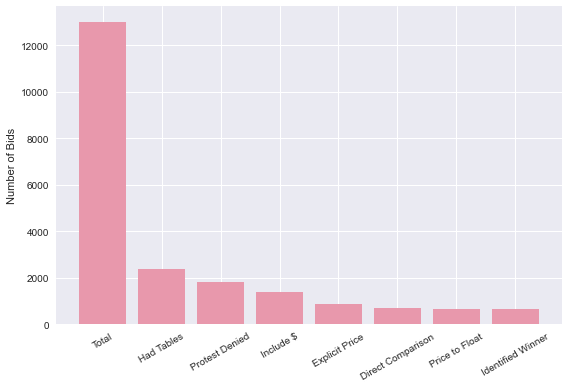

In [21]:
# Creating a graphic for our data cleaning funnel
import matplotlib.pyplot as plt
plt.style.use('seaborn')

data = {"Total": 13021,
        "Had Tables": 2379,
        "Protest Denied": 1809,
        "Include $": 1389,
        "Explicit Price": 878,
        "Direct Comparison": 698,
        "Price to Float": 680,
        "Identified Winner": 670
        }

plt.bar(data.keys(), data.values(), color='#e898ac')
plt.ylabel('Number of Bids')
plt.xticks(rotation=30)
plt.tight_layout()
#plt.savefig('./Project Screenshots/DataFunnel.png', dpi=300);

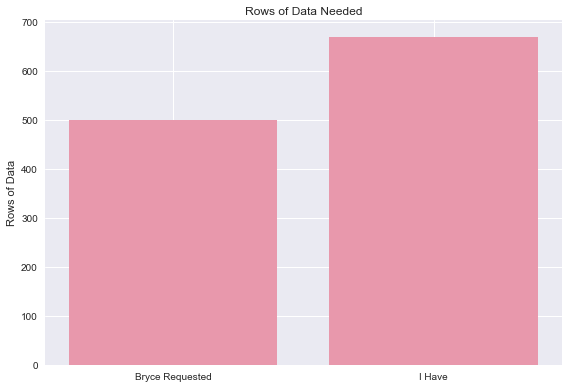

In [22]:
# Creating a joke
plt.bar(['Bryce Requested', 'I Have'], [500, 670], color='#e898ac')
plt.ylabel('Rows of Data')
plt.title('Rows of Data Needed')
plt.tight_layout()
#plt.savefig('./Project Screenshots/NumRowsData.png', dpi=300)

In [23]:
raw_gao = pd.read_pickle('./data/gaodata.df')
gao_over_2011 = raw_gao[raw_gao['dateCompleted'].dt.year >= 2011]
publishing_time = np.mean(gao_over_2011['datePublished'] - gao_over_2011['dateCompleted']).days
print("Days it takes to publish decisions once made:", publishing_time)

FileNotFoundError: [Errno 2] No such file or directory: './data/gaodata.df'

In [ ]:
# DoD Processing funnel:
# Total Bid Decisions listed on site:     8460
# Total Bid Decisions collected:          8417
# Total Bids containing explainations:    7976
# Total Bids containing tables:            908
# Total tables containing price:           908

Hilights in the GAO bid proposals show exactly who won the contract in the first sentence

"Ripple Effect Communications, Inc., a small business of Rockville, Maryland, protests the award of a contract to Goldbelt Frontier, LLC, also a small business, of Alexandria, Virginia, under request for proposals (RFP) No. W81XWH-19-R-0098, issued by the Department of the Army, U.S. Army Medical Research Acquisition Activity, for senior scientific support services for the Congressionally Directed Medical Research Programs."

https://www.gao.gov/products/b-418660.2